In [29]:
import sys
import os
root_dir = os.getcwd().replace('/Notebooks','')
sys.path.insert(1, root_dir)
sys.path.append('../modules/')
import pandas as pd
import numpy as np
from datetime import datetime as dt
import glob
from zipline.utils.run_algo import load_extensions
from zipline.data import bundles
from zipline.data.data_portal import DataPortal
from zipline.utils.calendar_utils import get_calendar
import os
load_extensions(
    default=True,
    extensions=[],
    strict=True,
    environ=os.environ,
)
from zipline.data.bundles import register, unregister
from zipline.data.bundles.csvdir import csvdir_equities
from zipline.utils.calendar_utils import register_calendar, get_calendar
# from exchange_calendars.exchange_calendar_xdse import XDSExchangeCalendar
from logbook import (NestedSetup, NullHandler, Logger, StreamHandler, StderrHandler, 
                     INFO, WARNING, DEBUG, ERROR)
from zipline.api import (order, 
                         record, 
                         symbol,
                         get_datetime,
                         order_target_percent,
                         order_target_value,
                         order_value,
                         set_benchmark,
                         get_open_orders)
from zipline import run_algorithm
from zipline.utils.calendar_utils import get_calendar
from zipline.api import order_target, record, symbol
from pyfolio.tears import create_full_tear_sheet
from pyfolio.utils import extract_rets_pos_txn_from_zipline
import seaborn as sns
import quantstats as qs
import yfinance as yf
from hurst import compute_Hc, random_walk
import warnings
warnings.filterwarnings('ignore')
import ensemble_trading_strategy as ets
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Signal on positive returns and negative returns

In [30]:
def get_signal(df:pd.DataFrame,periods=2):
    """
    this function receives a dataframe and calculte returns
    if the return is higher than 2 percent then it sends 1 as sell signal 
    and if the return is less than 2 percent then it sends -1 as buy signal
    otherwise it sends 0 as hold signal
    """
    returns = df.close.pct_change(periods=2).mul(100)
    signals = np.where(returns > 2,-1,0)
    signals = np.where(returns < -2, 1, returns)
    return signals[-1]

In [34]:
start = '2018-01-01'
end = '2023-01-01'
capital_base = 10000
calendar = get_calendar('NYSE')
symb = "AAPL"
bundle_data = bundles.load("sp50")
window = 90

def initialize(context):
    context.i = 0
    sids = bundle_data.asset_finder.sids
    context.assets = [symbol(symb)]


def handle_data(context, data):
    # Skip first 90 days to get full windows
    context.i += 1
    if context.i < window+1:
        return
    
    for asset in context.assets:
        df = data.history(asset,['open','high','low','close','volume'],bar_count=window,frequency='1d')
        curr_price = data.current(asset,'price')
        signal = ets.group3_ensemble_model_signals(df)
        # signal = get_signal(df)

        if signal == 1:
            order_target_percent(asset, 0.2)
        elif signal == -1:
            order_target_percent(asset, 0,stop_price=(curr_price * 0.9))
        else:
            pass
    

result = run_algorithm(start=pd.Timestamp(start),
                        end=pd.Timestamp(end),
                        initialize=initialize,
                        handle_data=handle_data,
                        capital_base=capital_base,
                        trading_calendar=calendar,
                        bundle='sp50',
                        data_frequency='daily',
                        )


[*********************100%%**********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2018-05-14   2018-05-14
End Period                 2022-12-30   2022-12-30
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       98.0%

Cumulative Return          40.76%       4.17%
Mean Active Return         0.0%         -0.03%
CAGR﹪                     5.23%        0.61%

Sharpe                     0.44         0.15
Prob. Sharpe Ratio         82.88%       62.67%
Smart Sharpe               0.42         0.14
Sortino                    0.62         0.19
Smart Sortino              0.59         0.18
Sortino/√2                 0.44         0.14
Smart Sortino/√2           0.42         0.13
Omega                      1.03         1.03

Max Drawdown               -33.92%      -18.98%
Longest DD Days            361          461
Volatility (ann.)          22.11%       7.85%
R^2                        0.11         0.11
Calmar               

None

-0.026064116090045792





,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2022-01-04,2022-12-29,2022-12-30,361,-18.978639,-13.916901
2,2020-02-13,2020-03-20,2020-07-02,141,-9.862798,-8.865252
3,2020-09-02,2021-03-30,2021-12-06,461,-6.935740,-6.907222
4,2019-05-06,2019-06-05,2019-10-18,166,-5.202930,-4.403796
5,2018-10-04,2018-12-19,2019-02-01,121,-4.152044,-4.114312


Average Long Exposure = 1959.2069920571882
Average Short Exposure = -219.26316362192213
Average Net Leverage = 0.15063704099795303
Average Gross Leverage = 0.18992625650343298
Max Leverage = 2.0169329298580116



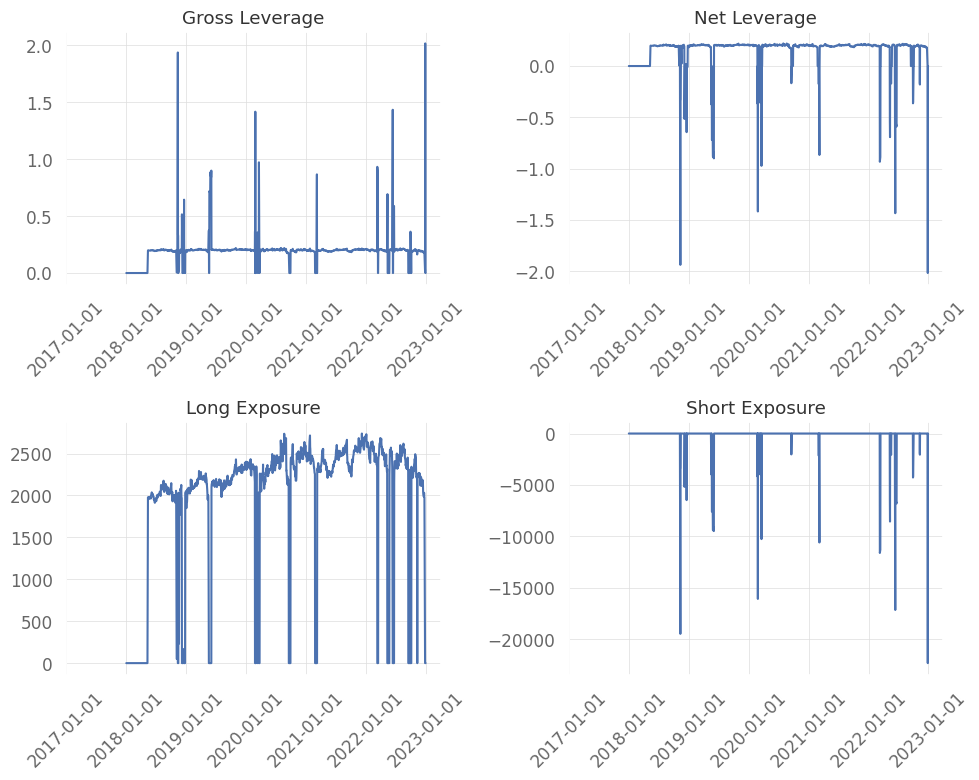

AAPL


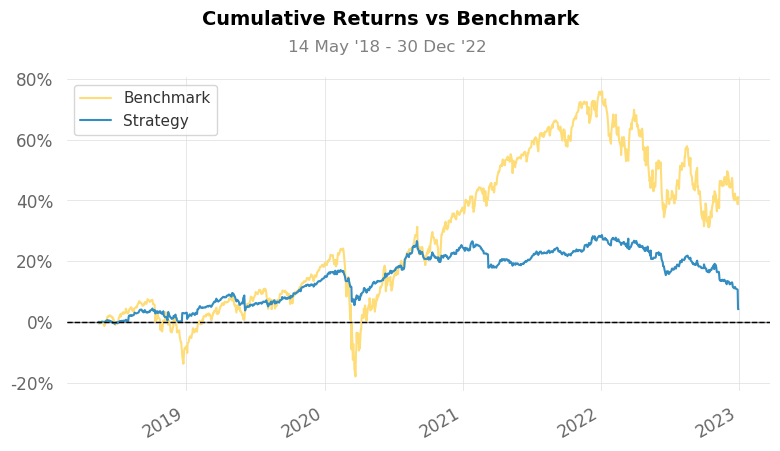

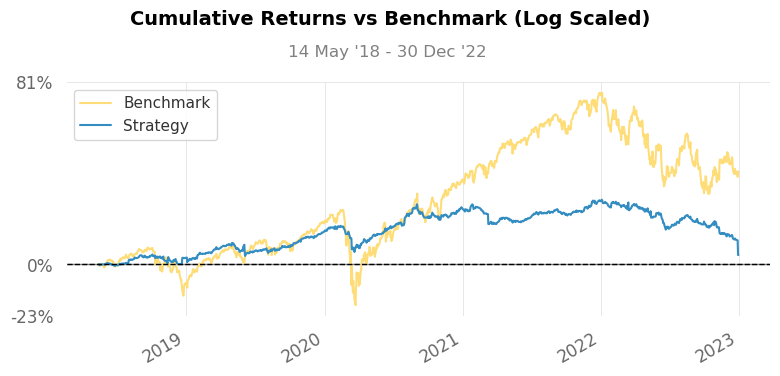

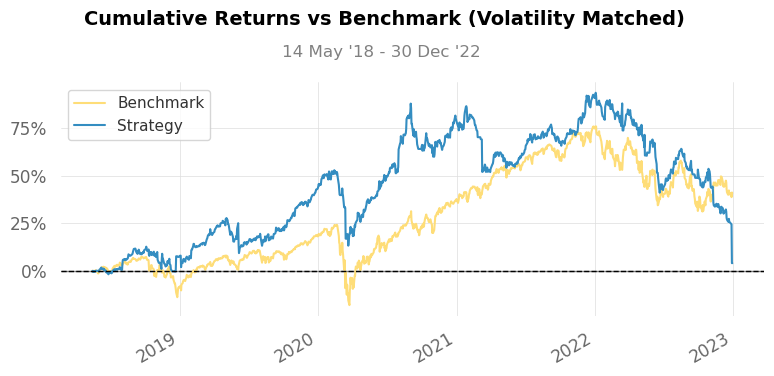

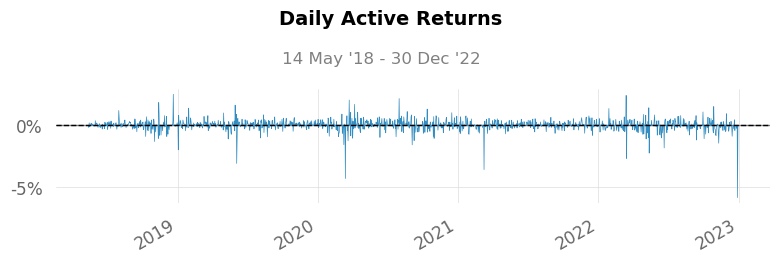

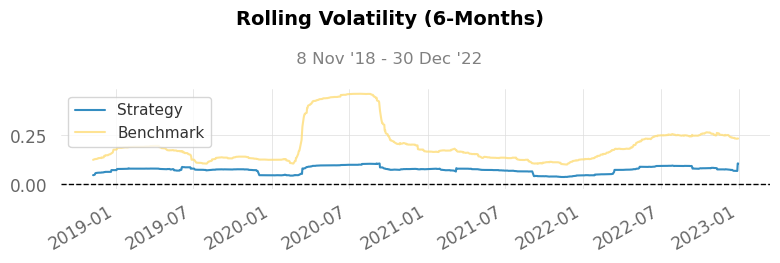

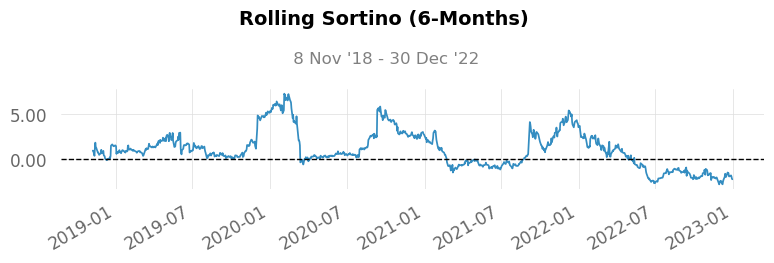

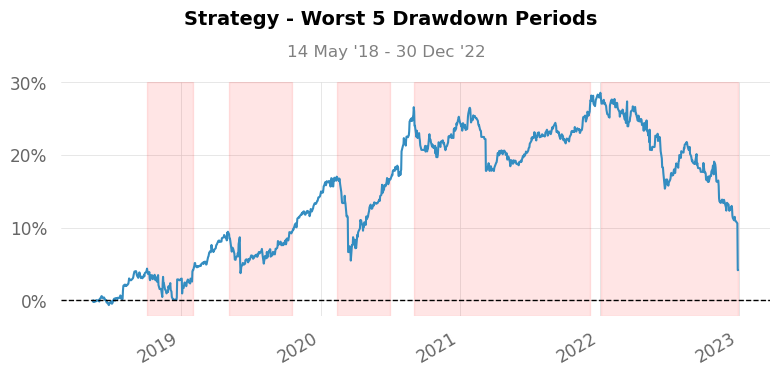

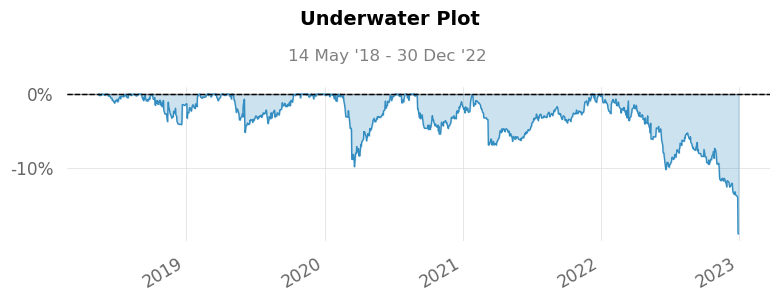

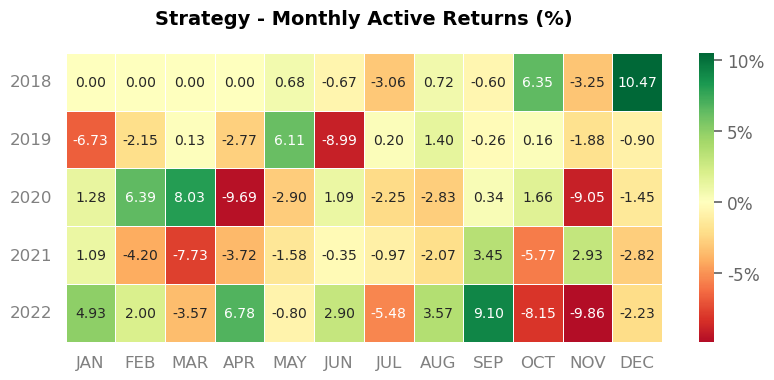

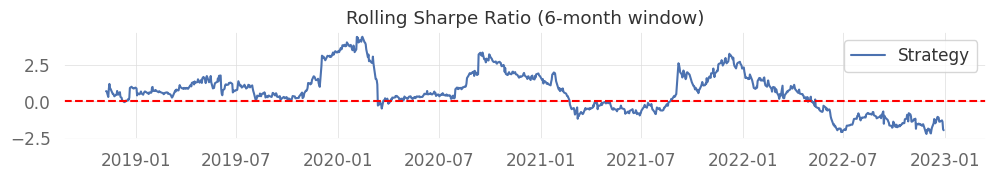

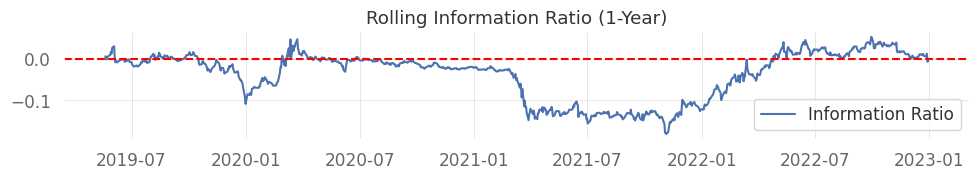

[*********************100%%**********************]  1 of 1 completed


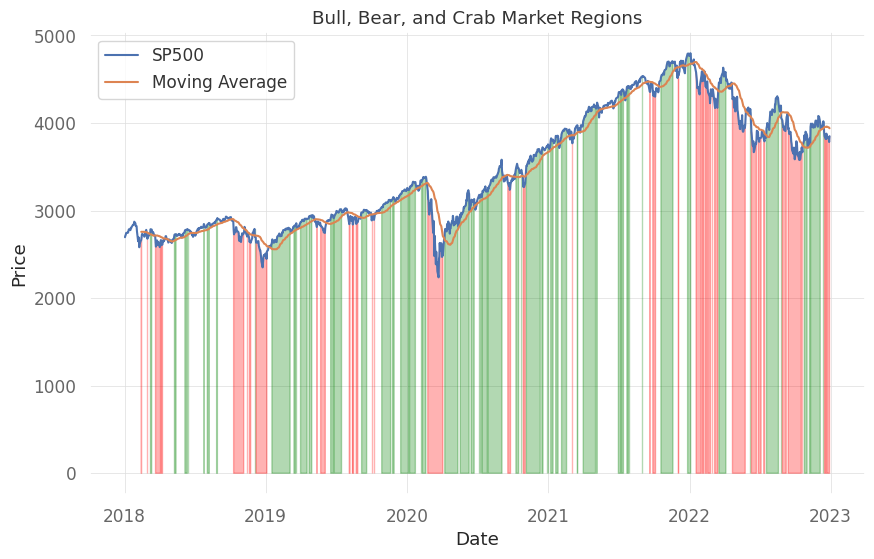

Total Trades: 230
Daily Trades: 1
Weekly Trades: 5
Monthly Trades: 21





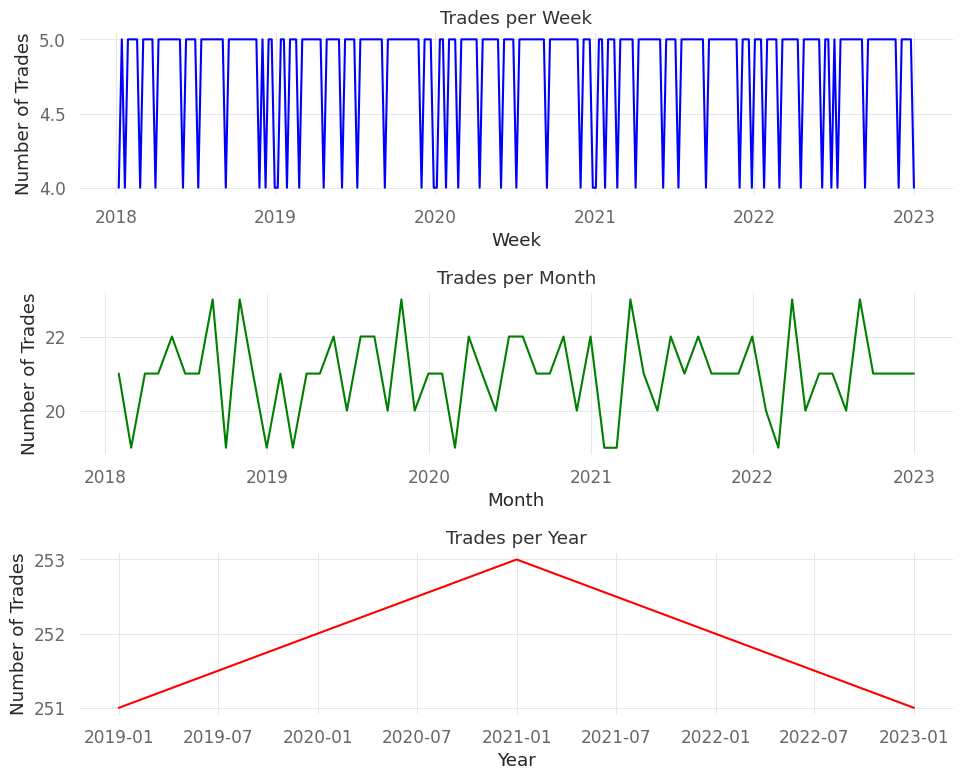

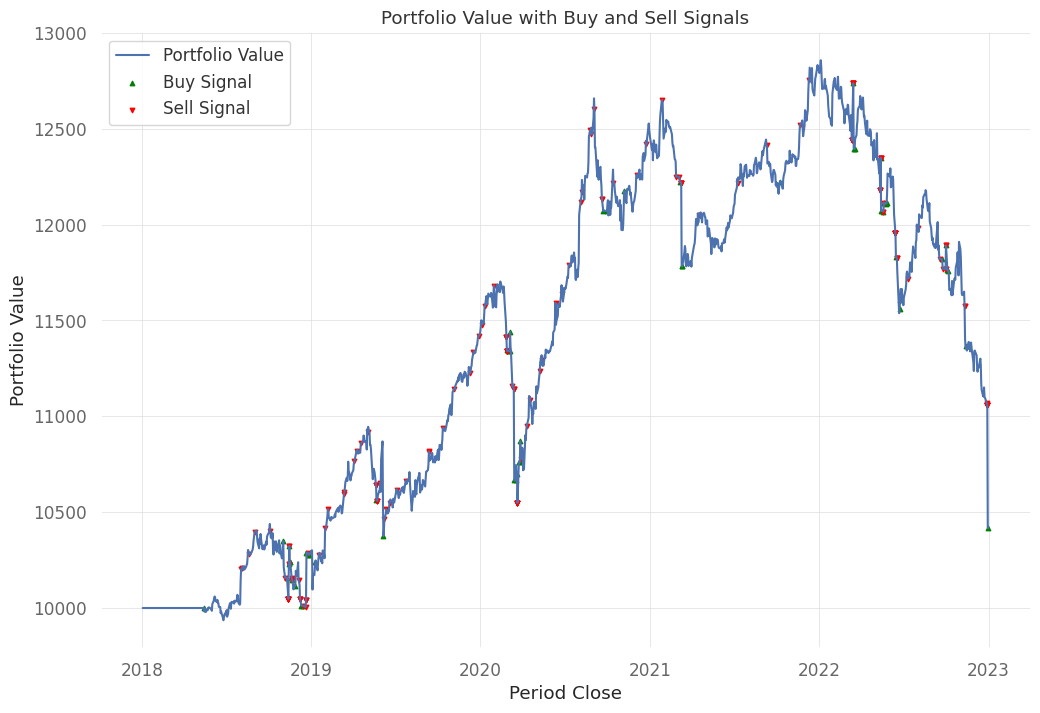

In [35]:
start = result.index[0]
end = result.index[-1]
benchmark = yf.download('^GSPC', start=start, end=end)['Adj Close'].pct_change()
result.index = pd.to_datetime(result.index).tz_convert(None)
result.index = benchmark.index    
qs.reports.full(result['returns'], benchmark = benchmark, match_dates=True, figsize=(8, 4), df = result)